Read pulsar data taken from the CSIRO DAP at  
https://data.csiro.au/dap/search?q=pulsars  
and interpret according to psrfits format described at  
http://www.atnf.csiro.au/people/pulsar/index.html?n=Main.Psrfits  
(detailed view at http://www.atnf.csiro.au/people/pulsar/index.html?n=PsrfitsDocumentation.Txt)  

Authors: Pulsar Voices team
http://www.the-hackfest.com/events/melbourne-science-hackfest/projects/pulsar-voices/


In [26]:
%matplotlib inline

In [27]:
import numpy as np
import scipy.signal as ss
import astropy
from astropy.io import fits
import matplotlib.pyplot as plt

In [28]:
cd ~/pulsarvoices/data

/Users/gary/pulsarvoices/data


In [29]:
ls

p130712_234328.rf  pulsarsound.wav    t130131_070547.rf


In [30]:
hdulist = fits.open('p130712_234328.rf')

In [31]:
hdulist.info()

Filename: p130712_234328.rf
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      64   ()              
1    HISTORY     BinTableHDU     71   2R x 28C     [24A, 80A, 8A, 8A, 1I, 1I, 1I, 1I, 1D, 1D, 1I, 1D, 1D, 1D, 1I, 1I, 1I, 1I, 1I, 32A, 32A, 32A, 32A, 32A, 32A, 1I, 32A, 1I]   
2    PSRPARAM    BinTableHDU     12   12R x 1C     [128A]   
3    POLYCO      BinTableHDU     38   1R x 13C     [24A, 16A, 1I, 1I, 1I, 8A, 1D, 1D, 1D, 1D, 1D, 1D, 15D]   
4    SUBINT      BinTableHDU     87   9R x 20C     [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1E, 1E, 1E, 1E, 1E, 1D, 1D, 512E, 512E, 2048E, 2048E, 2097152I]   


In [32]:
# Object name
hdulist['PSRPARAM'].data[0][0]

'PSRJ           \tJ0738-4042'

In [33]:
hdulist['PSRPARAM'].data

FITS_rec([('PSRJ           \tJ0738-4042'),
       ('RAJ            \t07:38:32.329             1.000e-02'),
       ('DECJ           \t-40:42:40.94             1.000e-01'),
       ('DM             \t160.8                    7.000e-01'),
       ('PEPOCH         \t51700.00'),
       ('F0             \t2.66723578343            5.000e-11'),
       ('F1             \t-1.1497E-14              7.000e-18'),
       ('PMRA           \t-14.0                    1.200e+00'),
       ('PMDEC          \t13                       2.000e+00'),
       ('POSEPOCH       \t51360.0'),
       ('RM             \t12.1                     6.000e-01'),
       ('EPHVER         \t2')], 
      dtype=(numpy.record, [('PARAM', 'S128')]))

In [34]:
type(hdulist['SUBINT'].data)

astropy.io.fits.fitsrec.FITS_rec

In [35]:
from astropy.io.fits import getdata

In [36]:
getdata('p130712_234328.rf', 'SUBINT', 0)

FITS_rec([ (0.0, 31.98041088000004, 0.0, 18053.00972124792, 114.63470416666665, -40.711372222222217, -105.80648040771484, -105.80648040771484, 0.0, 0.0, -88.647949, 115.60968, 32.255878, 0.0, 0.0, array([ 1581.60900879,  1580.82800293,  1580.04602051,  1579.26501465,
        1578.48400879,  1577.70300293,  1576.92102051,  1576.14001465,
        1575.35900879,  1574.57800293,  1573.79602051,  1573.01501465,
        1572.23400879,  1571.45300293,  1570.67102051,  1569.89001465,
        1569.10900879,  1568.32800293,  1567.54602051,  1566.76501465,
        1565.98400879,  1565.20300293,  1564.42102051,  1563.64001465,
        1562.85900879,  1562.07800293,  1561.29602051,  1560.51501465,
        1559.73400879,  1558.95300293,  1558.17102051,  1557.39001465,
        1556.60900879,  1555.82800293,  1555.04602051,  1554.26501465,
        1553.48400879,  1552.70300293,  1551.92102051,  1551.14001465,
        1550.35900879,  1549.57800293,  1548.79602051,  1548.01501465,
        1547.23400879,

In [37]:
freq_bins = hdulist['SUBINT'].data[0][-5]

In [38]:
hdulist['SUBINT'].data[0][-4].shape

(512,)

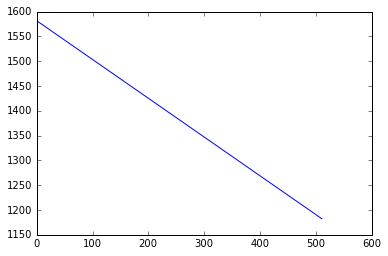

In [39]:
plt.plot(hdulist['SUBINT'].data[0][-5])

In [40]:
data1 = hdulist['SUBINT'].data[0][-1]
data1.shape

(4, 512, 1024)

In [41]:
# From http://stackoverflow.com/questions/2459295/invertible-stft-and-istft-in-python
import scipy, pylab

def stft(x, fs, framesz, hop):
    framesamp = int(framesz*fs)
    hopsamp = int(hop*fs)
    w = scipy.hanning(framesamp)
    X = scipy.array([scipy.fft(w*x[i:i+framesamp]) 
                     for i in range(0, len(x)-framesamp, hopsamp)])
    return X

def istft(X, fs, T, hop):
    x = scipy.zeros(T*fs)
    framesamp = X.shape[1]
    hopsamp = int(hop*fs)
    for n,i in enumerate(range(0, len(x)-framesamp, hopsamp)):
        x[i:i+framesamp] += scipy.real(scipy.ifft(X[n]))
    return x

def istft2(X, overlap=4):   
    fftsize=(X.shape[1]-1)*2
    hop = fftsize / overlap
    w = scipy.hanning(fftsize+1)[:-1]
    x = scipy.zeros(X.shape[0]*hop)
    wsum = scipy.zeros(X.shape[0]*hop) 
    for n,i in enumerate(range(0, len(x)-fftsize, hop)): 
        x[i:i+fftsize] += scipy.real(np.fft.irfft(X[n])) * w   # overlap-add
        wsum[i:i+fftsize] += w ** 2.
    pos = wsum != 0
    x[pos] /= wsum[pos]
    return x

In [42]:
polar1 = data1[0]
chirp = polar1[100:450]

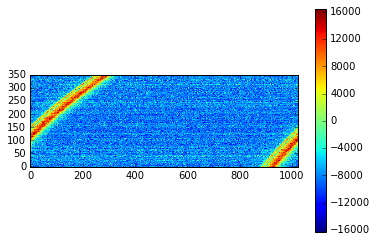

In [43]:
plt.imshow(chirp, origin='lower')
plt.colorbar()

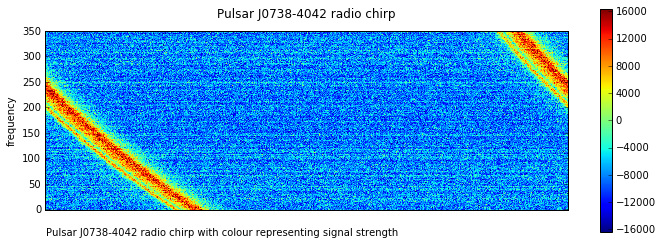

In [63]:
ax = plt.matshow(chirp[::-1], origin='lower')
plt.xlabel('time')
plt.gca().get_xaxis().set_visible(False)
#plt.gca().set_major_formatter(plt.NullFormatter())
plt.ylabel('frequency')
plt.title('Pulsar J0738-4042 radio chirp')
plt.colorbar()
plt.text(0.5, -50, 'Pulsar J0738-4042 radio chirp with colour representing signal strength')

In [44]:
fs = 16000
T = 2
hop = 200./fs
# isf = istft(data1[0].T, fs, T, hop)
isf = istft2(chirp, overlap=300)

In [45]:
from scipy.io import wavfile

def write_wavfile(data, fs, filename='pulsarsound.wav'):
    d = np.int16(data * 0.9 / np.max(np.abs(data)) * 32767)
    wavfile.write(filename, int(fs), d)

def note(sig, time, fname='pulsarsound.wav'):
    rate = int(float(sig.size) / time)
    print rate
    wavfile.write(fname, rate, sig)

write_wavfile(isf, 1000)
#note(isf, 2)

(-1000.0, 1000.0)

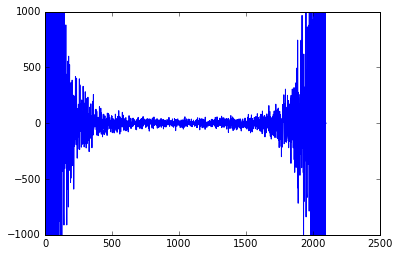

In [46]:
plt.plot(isf)
plt.ylim(-1e3, 1e3)

In [47]:
pwd

u'/Users/gary/pulsarvoices/data'

Docs for
SUBINTEGRATION DATA BINARY TABLE EXTENSION

Table containing the observed power spectra, that is spectra after detection or multiplication. Two modes of observation are catered for:

fold mode: where the data are synchronously folded at the apparent period of a pulsar using a Tempo polyco file or a Tempo2 predictor file and samples are binned in pulse phase
search mode: where streamed multichannel data are recorded in successive samples.
In both modes, the data can have a single polarisation (normally the sum of two orthogonal polarisations), two orthogonal polarisations or all four polarisation spectra.

In fold mode, data are summed over a sub-integration time and successive sub-integrations are stored in successive rows of the BINTABLE. In search mode, data are blocked in groups of NSBLK samples and stored in successive rows of the BINTABLE. To avoid excessive overheads, NSBLK is typically 4096.

Fold-mode data are stored as 16-bit signed integers with elements of the data array in bin, channel and polarisation order with the pulse profile bins in contiguous locations. Before conversion to integers, the mean channel power (averaged over bins and polarisations) during the sub-integration is subtracted from the channel data and the residual is scaled so that the values in the DATA array cover the whole available range (-32768 to 32767). The original observed powers are reconstructed using:

Real value = DATA value * DAT_SCL + DAT_OFFS.
Search-mode data may be stored as 1-bit, 2-bit, 4-bit or 8-bit signed or unsigned integers and are written as a byte array. Data digitised with less than 8 bits are packed with earlier samples in higher-order bits of the byte (i.e., "big-endian"). Elements of the data array are in channel, polarisation and sample order with the spectral channels in contiguous locations.

Prior to few-bit digitisation, search-mode sample spectra are generally normalised and given zero mean by forming (S-R)/R, where S is the observed spectrum and R is an estimate of the bandpass or reference spectrum. This effectively does a bandpass calibration and gives an approximately constant rms deviation across the spectrum in order to optimise the few-bit digitisation. These data are normally analysed directly without application of the scale factors and offsets. If required, the reference spectrum may be reconstructed from the DAT_OFFS and DAT_SCL fields of the table. However note that, if channel running means are used to form the reference spectrum, the recorded values are sampled at sub-integration intervals and do do not necessarily represent the exact values used to form the recorded spectra.

When unsigned integers are used to record the truncated data, a zero offset (ZERO_OFFS) is added to the digitised value. Normally ZERO_OFFS = 2^(NBIT - 1) - 0.5, but for total-intensity multi-bit data, a smaller value may be used to give more headroom. The original observed values are reconstructed using:

Real value = (DATA value - ZERO_OFFS) * DAT_SCL + DAT_OFFS.
The output data for long search-mode observations may be split in time or frequency and recorded in separate files to keep file sizes at manageable values. It is assumed that the data sampling is continuous across the split files.

XTENSION= BINTABLE / ***** Subintegration data ***** 
BITPIX = 8 / N/A 
NAXIS = 2 / 2-dimensional binary table 
NAXIS1 = * / width of table in bytes 
NAXIS2 = * / Number of rows in table (NSUBINT) 
PCOUNT = 0 / size of special data area 
GCOUNT = 1 / one data group (required keyword) 
TFIELDS = 18 / Number of fields per row

Standard FITS Binary Table header
INT_TYPE= ' ' / Time axis (TIME, BINPHSPERI, BINLNGASC, etc)

Normally data are recorded with a uniform time axis, i.e., sub-integrations are spaced by equal time intervals. However, in post-processing it is possible to make the nominal time axis non-linear, to represent for example, binary orbital phase or longitude. This keyword describes the form of the nominal time axis.
INT_UNIT= ' ' / Unit of time axis (SEC, PHS (0-1), DEG)

Units of the nominal time axis.
SCALE = ' ' / Intensity units (FluxDen/RefFlux/Jansky)

Units of the data.
POL_TYPE= ' ' / Polarisation identifier (e.g., AABBCRCI, AA+BB)

A string describing the type of polarisation data, e.g., for NPOL=1 total-intensity data (summed orthogonal polarisations), "AA+BB" may be used, where AA represents the auto-spectrum of the A channel and BB represents the auto-spectrum of the B channel. For NPOL=2, "AABB" may be used. For full polarisation data, "AABBCRCI" may be used where CR represents the real part of the A* B cross-spectrum and CI represents the imaginary part. For calibrated Stokes parameters, "IQUV" is normally used.
NPOL = * / Nr of polarisations

The number of polarisation products contained in the DATA table.
TBIN = * / [s] Time per bin or sample

For fold-mode data, the bin width in seconds; for search-mode data, the sampling interval in seconds.
NBIN = * / Nr of bins (PSR/CAL mode; else 1)

The number of bins in the fold-mode profile. For search-mode data, this parameter is irrelevant and normally set to 1.
NBIN_PRD= * / Nr of bins/pulse period (for gated data)

For observations where only part of the pulse profile is recorded (gated data), NBIN_PRD is the number of bins that the full pulse period would occupy. For example, if 256 bins are recorded across one quarter of the pulse period, NBIN = 256 and NBIN_PRD = 1024.
Alternatively, if more than one pulse period is contained within the recorded pulse profile, then NBIN_PRD is a sub-multiple of NBIN.

PHS_OFFS= * / Phase offset of bin 0 for gated data

For gated data, the value of pulse phase (in the range 0 - 1.0) corresponding to the leading edge of the first (index zero) bin in the folded profile.
NBITS = * / Nr of bits/datum (SEARCH mode data, else 1)

For search-mode data, the number of bits per sample datum. Ignored for fold-mode data.
ZERO_OFF= * / Zero offset for SEARCH-mode data

For data recorded as unsigned integers, the offset of the nominal data zero in digitiser units (actual data value = unsigned integer value - ZERO_OFF).
SIGNINT = * / 1 for signed ints in SEARCH-mode data, else 0

A flag to indicate that the data values are signed integers rather than unsigned integers.
NSUBOFFS= * / Subint offset (Contiguous SEARCH-mode files)

For files split in time, NSUBOFFS is the accumulated sub-integration count at the start of this file (such that true index value = file index value + NSUBOFFS).
NCHAN = * / Number of channels/sub-bands in this file

Number of frequency channels for each polarisation
CHAN_BW = * / [MHz] Channel/sub-band width

Channel bandwidth in MHz. Note that CHAN_BW < 0 implies decreasing frequency with increasing channel number.
DM = * / [cm-3 pc] DM for post-detection dedisperion

Dispersion measure used for post-detection dedispersion.
RM = * / [rad m-2] RM for post-detection deFaraday

Rotation measure used for post-detection correction of Faraday rotation
NCHNOFFS= * / Channel/sub-band offset for split files

For files split in frequency, NCHNOFFS is the true channel index of the first channel in this file (true index value = file index value + NCHNOFFS).
NSBLK = * / Samples/row (SEARCH mode, else 1)

For search-mode data, the number of samples in one table row or sub-integration.
NSTOT = * / Total number of samples (SEARCH mode, else 1)

Total number of valid samples in a search-mode file. This is useful since the last row may not be completely filled. Note, for split files, NSTOT should be the number of samples in that file, i.e., not accumulated over the whole observation.
EXTNAME = SUBINT / name of this binary table extension

TTYPE# = INDEXVAL / Optionally used if INT_TYPE != TIME 
TFORM# = 1D / Double

If INT_TYPE is not "TIME", this column gives the value of the time-like coordinate at the sub-integration centre, expressed in appropriate units (e.g., degrees for longitude).
TTYPE# = TSUBINT / Length of subintegration 
TFORM# = 1D / Double 
TUNIT# = s / Units of field

Duration of sub-integration (or row for search-mode data)
TTYPE# = OFFS_SUB / Offset from Start of subint centre 
TFORM# = 1D / Double 
TUNIT# = s / Units of field

Time since the observation start at the centre of each sub-integration (or row).
TTYPE# = LST_SUB / LST at subint centre 
TFORM# = 1D / Double 
TUNIT# = s / Units of field

Approximate local sidereal time at the sub-integration centre
TTYPE# = RA_SUB / RA (J2000) at subint centre 
TFORM# = 1D / Double 
TUNIT# = deg / Units of field

Pointing J2000 Right Ascension at the time of the sub-integration centre. For scanning observations this may change with time.
TTYPE# = DEC_SUB / Dec (J2000) at subint centre 
TFORM# = 1D / Double 
TUNIT# = deg / Units of field

Pointing J2000 Declination at the time of the sub-integration centre. For scanning observations this may change with time.

In [48]:
from astropy.coordinates import SkyCoord, spherical_to_cartesian

In [49]:
# Get coords of pulsar (ra, dec)
header = hdulist['PSRPARAM'].data
ra = header[1][0].split()[1]
dec = header[2][0].split()[1]
print ra, dec

07:38:32.329 -40:42:40.94


In [50]:
# Convert (ra, dec) to (x, y, z)
c = SkyCoord(ra, dec, frame='icrs', unit='deg')
spherical_to_cartesian(1, c.ra.radian, c.dec.radian)

(<Quantity 0.7512719861172099>,
 <Quantity -0.6464553302833068>,
 <Quantity 0.13298837852911632>)

---

In [64]:
ls

p130712_234328.rf                s130325_012143.rf.8channels.txt
pulsarsound.wav                  t130131_070547.rf


In [65]:
import pandas as pd

In [100]:
s13 = pd.read_csv('s130325_012143.rf.8channels.txt', delimiter=' ')
s13_data = np.array(s130325)[:,3]
s13_data = s13_data[:1024]
#s13_data = s13_data.reshape((-1,8))
#s13_data = s13_data.sum(axis=1)
s13_data.shape

(1024,)

In [132]:
s13_freq = 173.69
ts = np.linspace(0, 1.0/s13_freq, s13_data.size, endpoint=False)
ts

array([  0.00000000e+00,   5.62244516e-06,   1.12448903e-05, ...,
         5.74051651e-03,   5.74613895e-03,   5.75176140e-03])

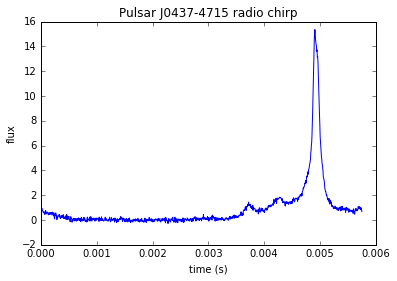

In [145]:
plt.plot(ts, s13_data)
plt.xlabel('time (s)')
#plt.gca().get_xaxis().set_visible(False)
plt.ylabel('flux')
plt.title('Pulsar J0437-4715 radio chirp')
plt.savefig('J0437-4715.png', dpi=72)

In [161]:
m = 1.0
n = s13_data
f_delta = np.max(n)
f_delta = 1.0
# From https://en.wikipedia.org/wiki/Frequency_modulation
#s = np.cos(2*np.pi*s13_freq*ts + 2*np.pi*f_delta*np.cumsum(n))
s = np.cos(2*np.pi*100000*ts + 2*np.pi*f_delta*np.cumsum(n))

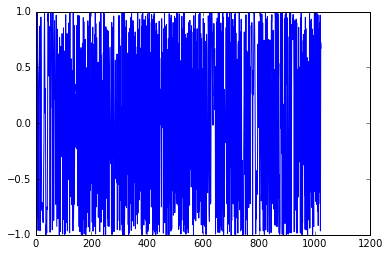

In [162]:
plt.plot(s)

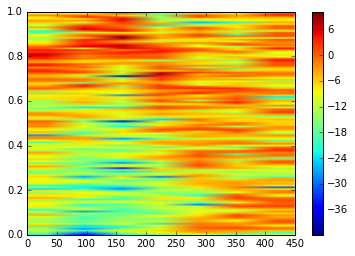

In [163]:
p = plt.specgram(s)
plt.colorbar()

In [164]:
write_wavfile(s, 1000)